In [1]:
import sys
import os
from pathlib import Path
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, get_interaction_operator
from openfermionpsi4 import run_psi4

add functions to automate the generation of hamiltonians with varying
number of active spaces, choice of mapping, choice of basis representation.

Getting this to run is a real pain in the neck...
1. Do a fresh conda install (openfermionpsi4 is specifically developed for anaconda apparently)
2. Install openfermion: conda install openfermion
3. Install psi4 and pip: (from the openfermionpsi4 github)
4. Install openfermionpsi4: (also from the openfermionpsi4 github

I found that even when I used a virtual environment, calling run_psi4() would still reach
out to the installed anaconda version resulting in seg faults that crashed the program.

https://github.com/quantumlib/OpenFermion-Psi4

In [24]:
def generate_and_save(geometry, basis, multiplicity, charge, description, mfilename):
    # initialize the molecule
    molecule = MolecularData(geometry,basis,multiplicity,charge,description=description,filename=mfilename)
    molecule.save()
    
    # compute the active space integrals
    print('-computing integrals-')
    molecule = run_psi4(molecule,run_mp2=True,run_cisd=True,run_ccsd=True,run_fci=True)
    
    print(molecule.filename)
    print(molecule.two_body_integrals)
    print(molecule.canonical_orbitals)
    molecule.save()    
    print('Successful generation')

In [3]:
def load_and_transform(filename, orbitals, transform):
    # Load data
    print('--- loading molecule ---')
    molecule = MolecularData(filename=filename)
    
    print('filename: {}'.format(molecule.filename))
    #print('n_atoms: {}'.format(molecule.n_atoms))
    #print('n_electrons: {}'.format(molecule.n_electrons))
    #print('n_orbitals: {}'.format(molecule.n_orbitals))
    #print('Canonical Orbitals: {}'.format(molecule.canonical_orbitals))
    #print('n_qubits: {}'.format(molecule.n_qubits))
    
    # get the Hamiltonian for a specific choice of active space
    # set the Hamiltonian parameters
    occupied_orbitals, active_orbitals = orbitals
    
    molecular_hamiltonian = molecule.get_molecular_hamiltonian(
                 occupied_indices=range(occupied_orbitals),
                 active_indices=range(active_orbitals))
    
    # map the operator to fermions and then qubits
    fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    
    # get interaction operator
    interaction_hamiltonian = get_interaction_operator(fermion_hamiltonian)
    
    if transform is 'JW':
        qubit_h = jordan_wigner(fermion_hamiltonian)
        qubit_h.compress()
    elif transform is 'BK':
        qubit_h = bravyi_kitaev(fermion_hamiltonian)
        qubit_h.compress()
    elif transform is 'BKSF':
        qubit_h = bravyi_kitaev_fast(interaction_hamiltonian)
        qubit_h.compress()
    elif transform is 'BKT':
        qubit_h = bravyi_kitaev_tree(fermion_hamiltonian)
        qubit_h.compress()
    elif transform is 'PC':
        qubit_h = binary_code_transform(fermion_hamiltonian, parity_code(2*active_orbitals))
        qubit_h.compress()
    else:
        print('ERROR: Unrecognized qubit transformation: {}'.format(transform))
        sys.exit(2)
        
    return qubit_h

In [22]:
def write_to_file(filename, name, hamiltonian, description):
    # write the resulting qubit H to file
    print('\n\n~~ writing Qubit Hamiltonian to file~~\n')
    print('filename: {}'.format(filename))
    with open(filename, 'w') as H_file:
        H_file.write('{} Qubit Hamiltonian\n'.format(name))
        hstring = '{}'.format(hamiltonian)
        terms = hstring.split('\n')
        for t in terms:
            t2 = t.split('[')
            if len(t2) is 2:
                coef = t2[0]
                paul = t2[1].split(']')[0]
                # Check for identity operator
                if paul is '':
                    paul = 'I0'
                    
                # Write coefficients and operators to file
                H_file.write('{0:17s} {1}\n'.format(coef,paul))
                
            else:
                print('ERROR: Something went wrong parsing string')
    print('Successful write\n')

In [5]:
def gen_multiple_AS(name,num_electrons,basis,transform,multiplicity,description,geometry,occupied_num):
    
    if multiplicity == 1:
        mult = 'singlet'
    elif multiplicity == 3:
        mult = 'triplet'
    else:
        print('Unknown Multiplicity')
        sys.exit()
        
    if not os.path.isdir('molecule_data/'):
        os.mkdir('molecule_data/')
    
    molecule_file = 'molecule_data/{}_{}_{}_{}'.format(name,basis,mult,description)

    print('--- Generate Molecule: {}_{}_{} ---'.format(name,basis,description))

    generate_and_save(geometry, basis, multiplicity, description, molecule_file)
                
    for active_num in range(1,occupied_num+1):
        # Load the molecule and perform qubit transformation
        orbitals = (occupied_num, active_num)

        qubit_h = load_and_transform(molecule_file, orbitals, transform)

        # Write the qubit hamiltonian to file
        folder = 'hamiltonians/'
        if not os.path.isdir(folder):
            os.makedirs(folder)
        fn = '{}_{}_{}_{}_AS{}.txt'.format(name,basis,transform,
                                           description,active_num)
        write_to_file(folder+fn,name,num_electrons,qubit_h,description)

In [25]:
def generate_hamiltonians(name, charge, multiplicity, description, geometry, occupied_num, active_num):
    """Generate 4 Hamiltonians for the given molecule:
    JW encoding + (STO-3G | 6-31G) basis
    BK encoding + (STO-3G | 6-31G) basis
    """
    if multiplicity == 1:
        mult = 'singlet'
    elif multiplicity == 2:
        mult = 'doublet'
    elif multiplicity == 3:
        mult = 'triplet'
    elif multiplicity == 4:
        mult = 'quartet'
    else:
        raise Exception('Unknown Multiplicity')
    
    if not os.path.isdir('molecule_data/'):
        os.mkdir('molecule_data/')
    
    for basis in ['sto-3g', '6-31g']:
        molecule_file = 'molecule_data/{}_{}_{}_{}'.format(name,basis,mult,description)
        
        print('--- Generate Molecule: {}_{}_{} ---'.format(name,basis,description))

        generate_and_save(geometry, basis, multiplicity, charge, description, molecule_file)
                
        # Load the molecule and perform qubit transformation
        orbitals = (occupied_num, active_num)

        for transform in ['JW', 'BK']:
            qubit_h = load_and_transform(molecule_file, orbitals, transform)

            # Write the qubit hamiltonian to file
            folder = 'hamiltonians/{}_{}/'.format(transform, basis)
            if not os.path.isdir(folder):
                os.mkdir(folder)
    
            fn = '{}_{}_{}_{}_AS{}.txt'.format(name,basis,transform, description,active_num)
            write_to_file(folder+fn,name,qubit_h,description)

In [6]:
def gen_multiple_encodings(name,num_electrons,basis,multiplicity,description,geometry,occupied_num,active_num):
    
    if multiplicity == 1:
        mult = 'singlet'
    elif multiplicity == 3:
        mult = 'triplet'
    else:
        print('Unknown Multiplicity')
        sys.exit()
    
    molecule_file = 'molecule_data/{}_{}_{}_{}'.format(name,basis,mult,description)

    print('--- Generate Molecule: {}_{}_{} ---'.format(name,basis,description))

    generate_and_save(geometry, basis, multiplicity, description, molecule_file)

    # Load the molecule and perform qubit transformation
    orbitals = (occupied_num, active_num)

    for transform in ['JW','BK','BKSF','BKT','PC']:
        qubit_h = load_and_transform(molecule_file, orbitals, transform)

        # Write the qubit hamiltonian to file
        folder = 'hamiltonians/'
        if not os.path.isdir(folder):
            os.makedirs(folder)
        fn = '{}_{}_{}_{}_AS{}.txt'.format(name,basis,transform,
                                           description,active_num)
        write_to_file(folder+fn,name,num_electrons,qubit_h,description)


In [7]:
from openfermion.transforms import (jordan_wigner, bravyi_kitaev, bravyi_kitaev_fast, bravyi_kitaev_tree,
                                    binary_code_transform, reverse_jordan_wigner)
from openfermion.transforms._binary_codes import parity_code

In [8]:
# Set molecule parameters for H2
name = 'H2'
basis = 'sto-3g'
multiplicity = 1
transform = 'BK'
num_electrons = 2
description = '0.7'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.7))]
occupied_num = 2

In [9]:
gen_multiple_AS(name,num_electrons,basis,transform,multiplicity,description,geometry,occupied_num)

--- Generate Molecule: H2_sto-3g_0.7 ---
-computing integrals-
molecule_data/H2_sto-3g_singlet_0.7
[[[[0.68238953 0.        ]
   [0.         0.17900058]]

  [[0.         0.17900058]
   [0.67073278 0.        ]]]


 [[[0.         0.67073278]
   [0.17900058 0.        ]]

  [[0.17900058 0.        ]
   [0.         0.70510563]]]]
[[ 0.54455869  1.26206594]
 [ 0.54455869 -1.26206594]]
Successful generation
--- loading molecule ---
filename: molecule_data/H2_sto-3g_singlet_0.7


~~ writing Qubit Hamiltonian to file~~

filename: hamiltonians/H2_sto-3g_BK_0.7_AS1.txt
Successful write

--- loading molecule ---
filename: molecule_data/H2_sto-3g_singlet_0.7


~~ writing Qubit Hamiltonian to file~~

filename: hamiltonians/H2_sto-3g_BK_0.7_AS2.txt
Successful write



In [10]:
active_num = 4
gen_multiple_encodings(name,num_electrons,basis,multiplicity,description,geometry,occupied_num,active_num)

--- Generate Molecule: H2_sto-3g_0.7 ---


FileNotFoundError: [Errno 2] No such file or directory: 'e8d53b29-c160-4dbc-8d2a-56f023cf28f7.hdf5' -> 'molecule_data/H2_sto-3g_singlet_0.7.hdf5'

In [11]:
# Set molecule parameters for H2O
name = 'H2O'
basis = 'sto-3g'
transform = 'BK'
multiplicity = 1
num_electrons = 8
description = '104'
geometry = [('O', (0.,0.,0.)), ('H', (0.757,0.586,0.)), ('H', (-0.757,0.586,0.))]
occupied_num = 6

In [12]:
gen_multiple_AS(name,num_electrons,basis,transform,multiplicity,description,geometry,occupied_num)

--- Generate Molecule: H2O_sto-3g_104 ---


FileNotFoundError: [Errno 2] No such file or directory: '30754abd-dfa1-4491-a473-77b18e1a668d.hdf5' -> 'molecule_data/H2O_sto-3g_singlet_104.hdf5'

In [12]:
active_num = 6
gen_multiple_encodings(name,num_electrons,basis,multiplicity,description,geometry,occupied_num,active_num)

--- Generate Molecule: H2O_sto-3g_104 ---
-computing integrals-
molecule_data/H2O_sto-3g_singlet_104
[[[[ 4.74449671e+00  4.16628272e-01 -5.64910088e-16 ... -5.44954633e-17
     2.38114701e-01 -5.25085448e-15]
   [ 4.16628272e-01  5.81701562e-02 -1.23008756e-16 ...  3.14690117e-17
     3.58157920e-02 -8.25922872e-16]
   [-5.86838772e-16 -1.28988132e-16  1.09952108e-02 ...  1.67792134e-17
     3.40752919e-16  1.53189768e-02]
   ...
   [-5.44954633e-17  3.14690117e-17  1.67792134e-17 ...  2.60448490e-02
    -2.41352490e-17 -1.06423608e-17]
   [ 2.38114701e-01  3.58157920e-02  3.45596599e-16 ... -2.41352490e-17
     3.13261688e-02 -2.12425074e-16]
   [-5.20162152e-15 -8.14896463e-16  1.53189768e-02 ... -1.06423608e-17
    -2.05291577e-16  2.14007499e-02]]

  [[ 4.16628272e-01  5.81701562e-02 -1.24457318e-16 ...  3.14690117e-17
     3.58157920e-02 -8.23293366e-16]
   [ 1.00455066e+00  1.29669539e-02  2.60370161e-16 ... -1.28165990e-16
     7.83123332e-04  1.58919973e-17]
   [-8.46225866e-1

In [10]:
# Set molecule parameters for Methane, CH4
# geometry taken from OpenFermion tutorial: 
# https://github.com/quantumlib/OpenFermion/blob/master/examples/openfermion_tutorial.ipynb
name = 'CH4'
basis = 'sto-3g'
transform = 'BK'
multiplicity = 1
mult = 'singlet'
num_electrons = 10
description = 'grnd'
geometry = [('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), 
            ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), 
            ('H', (-0.4593, 0.3874, -0.9121))]

# set Active Space parameters
occupied_num = 9

gen_multiple_AS(name,num_electrons,basis,transform,multiplicity,description,geometry,occupied_num)

--- Generate Molecule: CH4_sto-3g_grnd ---
-computing integrals-
molecule_data/CH4_sto-3g_singlet_grnd
[[[[ 3.50111808e+00  2.93359989e-01  1.10767442e-06 ... -3.28313798e-05
    -6.91012233e-05  3.26772351e-01]
   [ 2.93359989e-01  3.86008907e-02  2.06425379e-07 ... -4.34506685e-06
    -9.16302869e-06  4.38093713e-02]
   [ 1.10767442e-06  2.06425379e-07  8.77763273e-03 ... -8.81953045e-05
     1.34410199e-02  2.86638503e-06]
   ...
   [-3.28313798e-05 -4.34506685e-06 -8.81953045e-05 ...  2.07111511e-02
    -2.63509490e-08 -2.89584668e-06]
   [-6.91012233e-05 -9.16302869e-06  1.34410199e-02 ... -2.63509490e-08
     2.07122620e-02 -6.31082236e-06]
   [ 3.26772351e-01  4.38093713e-02  2.86638503e-06 ... -2.89584668e-06
    -6.31082236e-06  4.97918460e-02]]

  [[ 2.93359989e-01  3.86008907e-02  2.06425379e-07 ... -4.34506685e-06
    -9.16302869e-06  4.38093713e-02]
   [ 7.08049932e-01  9.18605309e-03 -1.41229460e-07 ... -1.13582449e-06
    -2.32160079e-06  9.68165213e-03]
   [ 3.55133593e

In [9]:
# Set molecule parameters for LiH
# geometry taken from OpenFermion tutorial: 
# https://github.com/quantumlib/OpenFermion/blob/master/examples/openfermion_tutorial.ipynb
name = 'LiH'
basis = 'sto-3g'
transform = 'BK'
multiplicity = 1
mult = 'singlet'
num_electrons = 4
description = '1.45'
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]

# set Active Space parameters
occupied_num = 6

gen_multiple_AS(name,num_electrons,basis,transform,multiplicity,description,geometry,occupied_num)

--- Generate Molecule: LiH_sto-3g_1.45 ---
-computing integrals-
molecule_data/LiH_sto-3g_singlet_1.45
[[[[ 1.65786417e+00  1.19871875e-01  1.37085378e-01  4.41750065e-17
    -2.41729399e-16  3.73084781e-02]
   [ 1.19871875e-01  1.55371060e-02  1.17356133e-02  5.32799975e-18
    -7.56163721e-18  7.55506066e-03]
   [ 1.37085378e-01  1.17356133e-02  2.14220899e-02  1.01870808e-17
    -1.57876208e-18  6.00201656e-04]
   [ 4.41750065e-17  5.32799975e-18  1.01870808e-17  9.82023135e-03
    -1.73472348e-18  7.57655802e-18]
   [-2.41729399e-16 -7.56163721e-18 -1.57876208e-18 -1.73472348e-18
     9.82023135e-03  2.65119469e-18]
   [ 3.73084781e-02  7.55506066e-03  6.00201656e-04  7.57655802e-18
     2.65119469e-18  6.48447501e-03]]

  [[ 1.19871875e-01  1.55371060e-02  1.17356133e-02  5.32799975e-18
    -7.56163721e-18  7.55506066e-03]
   [ 3.86346603e-01 -7.84668805e-03  1.77604020e-02 -1.05319828e-17
    -1.32502195e-16 -5.42420776e-03]
   [ 1.04776166e-02  3.84391977e-03 -2.61736809e-04  2.

## Generate test set of Hamiltonians for MICRO paper

In [26]:
# Set molecule parameters for H2
name = 'H2'
multiplicity = 1
charge = 0
description = '0.7'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.7))]
occupied_num = 2
active_num = 2
generate_hamiltonians(name,charge,multiplicity,description,geometry,occupied_num,active_num)

--- Generate Molecule: H2_sto-3g_0.7 ---
-computing integrals-
molecule_data/H2_sto-3g_singlet_0.7
[[[[0.68238953 0.        ]
   [0.         0.17900058]]

  [[0.         0.17900058]
   [0.67073278 0.        ]]]


 [[[0.         0.67073278]
   [0.17900058 0.        ]]

  [[0.17900058 0.        ]
   [0.         0.70510563]]]]
[[ 0.54455869  1.26206594]
 [ 0.54455869 -1.26206594]]
Successful generation
--- loading molecule ---
filename: molecule_data/H2_sto-3g_singlet_0.7


~~ writing Qubit Hamiltonian to file~~

filename: hamiltonians/JW_sto-3g/H2_sto-3g_JW_0.7_AS2.txt
Successful write

--- loading molecule ---
filename: molecule_data/H2_sto-3g_singlet_0.7


~~ writing Qubit Hamiltonian to file~~

filename: hamiltonians/BK_sto-3g/H2_sto-3g_BK_0.7_AS2.txt
Successful write

--- Generate Molecule: H2_6-31g_0.7 ---
-computing integrals-
molecule_data/H2_6-31g_singlet_0.7
[[[[ 6.65568116e-01 -4.09897420e-16  1.72481041e-01 -9.43463597e-17]
   [-3.50482870e-16  7.56290268e-02 -2.19696837e-16  

In [27]:
# Set molecule parameters for CH4 (methane)
name = 'CH4'
multiplicity = 1
charge = 0
description = 'grnd'
geometry = [('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), 
            ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), 
            ('H', (-0.4593, 0.3874, -0.9121))]
occupied_num = 9
active_num = 9
generate_hamiltonians(name,charge,multiplicity,description,geometry,occupied_num,active_num)

--- Generate Molecule: CH4_sto-3g_grnd ---
-computing integrals-
molecule_data/CH4_sto-3g_singlet_grnd
[[[[ 3.50111808e+00  2.93359989e-01  1.10767442e-06 ... -3.28313798e-05
    -6.91012233e-05  3.26772351e-01]
   [ 2.93359989e-01  3.86008907e-02  2.06425379e-07 ... -4.34506685e-06
    -9.16302869e-06  4.38093713e-02]
   [ 1.10767442e-06  2.06425379e-07  8.77763273e-03 ... -8.81953045e-05
     1.34410199e-02  2.86638503e-06]
   ...
   [-3.28313798e-05 -4.34506685e-06 -8.81953045e-05 ...  2.07111511e-02
    -2.63509490e-08 -2.89584668e-06]
   [-6.91012233e-05 -9.16302869e-06  1.34410199e-02 ... -2.63509490e-08
     2.07122620e-02 -6.31082236e-06]
   [ 3.26772351e-01  4.38093713e-02  2.86638503e-06 ... -2.89584668e-06
    -6.31082236e-06  4.97918460e-02]]

  [[ 2.93359989e-01  3.86008907e-02  2.06425379e-07 ... -4.34506685e-06
    -9.16302869e-06  4.38093713e-02]
   [ 7.08049932e-01  9.18605309e-03 -1.41229460e-07 ... -1.13582449e-06
    -2.32160079e-06  9.68165213e-03]
   [ 3.55133593e

KeyboardInterrupt: 

# Checking Fermionic Hamiltonian

In [2]:
def get_fermionic_H(filename, orbitals):
    # Load data
    print('--- loading molecule ---')
    molecule = MolecularData(filename=filename)
    
    print('filename: {}'.format(molecule.filename))
    #print('n_atoms: {}'.format(molecule.n_atoms))
    #print('n_electrons: {}'.format(molecule.n_electrons))
    #print('n_orbitals: {}'.format(molecule.n_orbitals))
    #print('Canonical Orbitals: {}'.format(molecule.canonical_orbitals))
    #print('n_qubits: {}'.format(molecule.n_qubits))
    
    # get the Hamiltonian for a specific choice of active space
    # set the Hamiltonian parameters
    occupied_orbitals, active_orbitals = orbitals
    
    molecular_hamiltonian = molecule.get_molecular_hamiltonian(
                 occupied_indices=range(occupied_orbitals),
                 active_indices=range(active_orbitals))
    
    # map the operator to fermions and then qubits
    fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    
    return fermion_hamiltonian

In [8]:
fermH = get_fermionic_H('molecule_data/Ethene_sto-3g_singlet_NIST.hdf5', (2,2))
terms = fermH.terms
print(fermH)
#print(terms['((0, 1), (1, 1), (11, 0), (6, 0))'])

--- loading molecule ---
filename: molecule_data/Ethene_sto-3g_singlet_NIST
-44.484517215793964 [] +
-17.305285386171043 [0^ 0] +
0.975395390390018 [0^ 0^ 0 0] +
-0.0001794823836595 [0^ 0^ 0 2] +
-0.00017948238365929648 [0^ 0^ 2 0] +
0.7762518877603799 [0^ 0^ 2 2] +
0.975395390390018 [0^ 1^ 1 0] +
-0.0001794823836595 [0^ 1^ 1 2] +
-0.00017948238365929648 [0^ 1^ 3 0] +
0.7762518877603799 [0^ 1^ 3 2] +
-3.531276781703111e-07 [0^ 2] +
-0.00017948238365943022 [0^ 2^ 0 0] +
0.7762518877603799 [0^ 2^ 0 2] +
0.9750696453094363 [0^ 2^ 2 0] +
0.00017955229675795583 [0^ 2^ 2 2] +
-0.00017948238365943022 [0^ 3^ 1 0] +
0.7762518877603799 [0^ 3^ 1 2] +
0.9750696453094363 [0^ 3^ 3 0] +
0.00017955229675795583 [0^ 3^ 3 2] +
0.975395390390018 [1^ 0^ 0 1] +
-0.0001794823836595 [1^ 0^ 0 3] +
-0.00017948238365929648 [1^ 0^ 2 1] +
0.7762518877603799 [1^ 0^ 2 3] +
-17.305285386171043 [1^ 1] +
0.975395390390018 [1^ 1^ 1 1] +
-0.0001794823836595 [1^ 1^ 1 3] +
-0.00017948238365929648 [1^ 1^ 3 1] +
0.7762518877

In [12]:
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner
fop = FermionOperator('0^ 1^ 11 6')
print(fop)
qubit_h = jordan_wigner(fop)
print(qubit_h)
print(len(qubit_h.terms))

1.0 [0^ 1^ 11 6]
(0.0625+0j) [X0 X1 X6 Z7 Z8 Z9 Z10 X11] +
0.0625j [X0 X1 X6 Z7 Z8 Z9 Z10 Y11] +
0.0625j [X0 X1 Y6 Z7 Z8 Z9 Z10 X11] +
(-0.0625+0j) [X0 X1 Y6 Z7 Z8 Z9 Z10 Y11] +
-0.0625j [X0 Y1 X6 Z7 Z8 Z9 Z10 X11] +
(0.0625+0j) [X0 Y1 X6 Z7 Z8 Z9 Z10 Y11] +
(0.0625+0j) [X0 Y1 Y6 Z7 Z8 Z9 Z10 X11] +
0.0625j [X0 Y1 Y6 Z7 Z8 Z9 Z10 Y11] +
-0.0625j [Y0 X1 X6 Z7 Z8 Z9 Z10 X11] +
(0.0625+0j) [Y0 X1 X6 Z7 Z8 Z9 Z10 Y11] +
(0.0625+0j) [Y0 X1 Y6 Z7 Z8 Z9 Z10 X11] +
0.0625j [Y0 X1 Y6 Z7 Z8 Z9 Z10 Y11] +
(-0.0625+0j) [Y0 Y1 X6 Z7 Z8 Z9 Z10 X11] +
-0.0625j [Y0 Y1 X6 Z7 Z8 Z9 Z10 Y11] +
-0.0625j [Y0 Y1 Y6 Z7 Z8 Z9 Z10 X11] +
(0.0625+0j) [Y0 Y1 Y6 Z7 Z8 Z9 Z10 Y11]
16


# Characterize the testset Hamiltonians

In [2]:
import glob
import matplotlib.pyplot as plt

In [3]:
hfiles = glob.glob('testset_hamiltonians/*.txt')
print(len(hfiles))

937


In [4]:
hamiltonians = []
for hfile in hfiles:
    molname = hfile.split('/')[-1].split('_')[0]
    with open(hfile, 'r') as hf:
        allLines = hf.readlines()
        num_terms = len(allLines) - 2
        numq = 0
        for i, line in enumerate(allLines):
            if i > 0:
                msb = int(line.split()[-1][1:])
                if msb > numq:
                    numq = msb
        numq = numq + 1
    hamiltonians.append((molname, num_terms, numq))

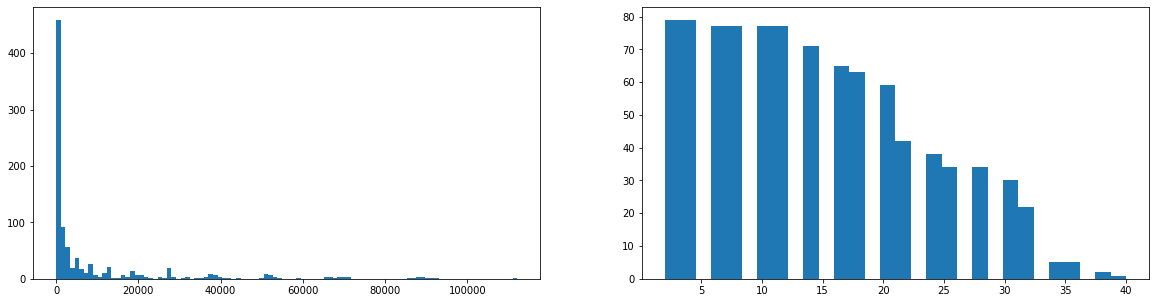

In [5]:
nterms = [h[1] for h in hamiltonians]
nqubits = [h[2] for h in hamiltonians]

fig, ax = plt.subplots(1,2, figsize=[20,5])
ax[0].hist(nterms, bins=100)
ax[1].hist(nqubits, bins=30)
plt.show()
plt.close()

In [17]:
exactUsize = 0
for h in hamiltonians:
    if h[2] < 15:
        exactUsize += 2**(2*h[2]+6)
print(exactUsize, 'bits')
print(exactUsize / 8e+9, 'Gbs')

1307960736768 bits
163.495092096 Gbs
